In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches

# (It may complain that some files are missing because the files seem to have been
# reorganized on the underlying website, but it still seems to work). If everything is working
# properly, then the whole notebook should run to the end without further problems
# even before you make changes.
batch_size_train = 64
batch_size_test = 1000

# TODO Change this directory to point towards an existing directory
myDir = './mnist_data'


train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(myDir, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(myDir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

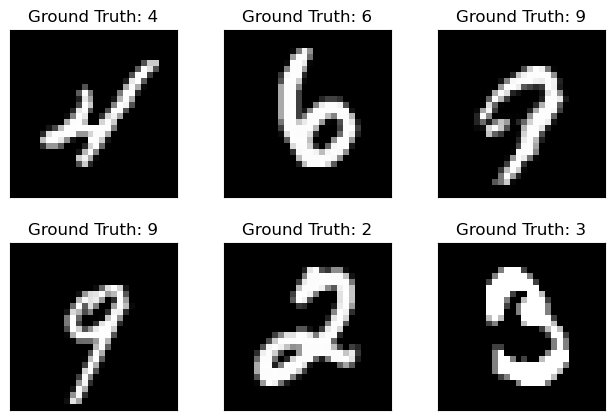

In [7]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [9]:
from os import X_OK
# TODO Change this class to implement
# 1. A valid convolution with kernel size 5, 1 input channel and 10 output channels
# 2. A max pooling operation over a 2x2 area
# 3. A Relu
# 4. A valid convolution with kernel size 5, 10 input channels and 20 output channels
# 5. A 2D Dropout layer
# 6. A max pooling operation over a 2x2 area
# 7. A relu
# 8. A flattening operation
# 9. A fully connected layer mapping from (whatever dimensions we are at-- find out using .shape) to 50
# 10. A ReLU
# 11. A fully connected layer mapping from 50 to 10 dimensions
# 12. A softmax function.

# Replace this class which implements a minimal network (which still does okay)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1. Valid convolution with kernel size 5, 1 input channel, 10 output channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)  # output: (10, 24, 24)

        # 2. Max pooling over 2x2 area
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # output: (10, 12, 12)

        # 4. Valid convolution with kernel size 5, 10 input channels, 20 output channels
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)  # output: (20, 8, 8)

        # 5. 2D Dropout
        self.dropout2d = nn.Dropout2d()

        # 6. Max pooling over 2x2 area
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # output: (20, 4, 4)

        # 9. Fully connected layer from 20*4*4 = 320 to 50
        self.fc1 = nn.Linear(320, 50)

        # 11. Fully connected layer from 50 to 10
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # 1. Conv -> 2. MaxPool -> 3. ReLU
        x = F.relu(self.pool1(self.conv1(x)))

        # 4. Conv -> 5. Dropout2d -> 6. MaxPool -> 7. ReLU
        x = F.relu(self.pool2(self.dropout2d(self.conv2(x))))

        # 8. Flatten
        x = torch.flatten(x, 1)  # flatten all dimensions except batch

        # 9. Fully connected -> 10. ReLU
        x = F.relu(self.fc1(x))

        # 11. Fully connected
        x = self.fc2(x)

        # 12. Softmax (use log_softmax for better stability in classification tasks)
        output = F.log_softmax(x, dim=1)
        return output






In [11]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [13]:
# Create network
model = Net()
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [15]:
# Main training routine
def train(epoch):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [17]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [19]:
# Get initial performance
test()
# Train for three epochs
n_epochs = 3
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\tarun\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.4721, Accuracy: 546/10000 (5%)

Train Epoch: 1 [0/60000]	Loss: 2.481580
Train Epoch: 1 [640/60000]	Loss: 2.221580
Train Epoch: 1 [1280/60000]	Loss: 2.130125
Train Epoch: 1 [1920/60000]	Loss: 2.120259
Train Epoch: 1 [2560/60000]	Loss: 1.859990
Train Epoch: 1 [3200/60000]	Loss: 1.450464
Train Epoch: 1 [3840/60000]	Loss: 1.413879
Train Epoch: 1 [4480/60000]	Loss: 1.201434
Train Epoch: 1 [5120/60000]	Loss: 1.049910
Train Epoch: 1 [5760/60000]	Loss: 0.930022
Train Epoch: 1 [6400/60000]	Loss: 0.908750
Train Epoch: 1 [7040/60000]	Loss: 0.935266
Train Epoch: 1 [7680/60000]	Loss: 0.437774
Train Epoch: 1 [8320/60000]	Loss: 0.708088
Train Epoch: 1 [8960/60000]	Loss: 0.968340
Train Epoch: 1 [9600/60000]	Loss: 0.540492
Train Epoch: 1 [10240/60000]	Loss: 0.579398
Train Epoch: 1 [10880/60000]	Loss: 0.674500
Train Epoch: 1 [11520/60000]	Loss: 0.458004
Train Epoch: 1 [12160/60000]	Loss: 0.405734
Train Epoch: 1 [12800/60000]	Loss: 0.437963
Train Epoch: 1 [13440/60000]	Loss: 0.648

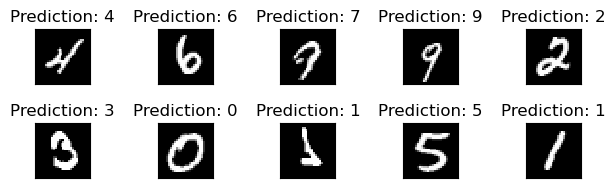

In [21]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()